## Try to replicate SMT on MNIST

In [1]:
import torch
import torch.optim as optim
from torchvision import datasets
from torchvision.transforms.v2 import ToTensor
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
import numpy as np
from tools import *

# Check that MPS is available
if not torch.backends.mps.is_available():
    if not torch.backends.mps.is_built():
        print("MPS not available because the current PyTorch install was not "
              "built with MPS enabled.")
    else:
        print("MPS not available because the current MacOS version is not 12.3+ "
              "and/or you do not have an MPS-enabled device on this machine.")

else:
    mbp = torch.device("mps")
    print("MPS is enabled!")

    # Create a Tensor directly on the mps device
    x = torch.ones(5, device=mbp)
    # Or
    x = torch.ones(5, device="mps")


training_data = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
)

test_data = datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)


MPS is enabled!


/Users/derek/anaconda3/envs/py11_pytorch2/lib/python3.11/site-packages/torchvision/transforms/v2/_deprecated.py:41: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(


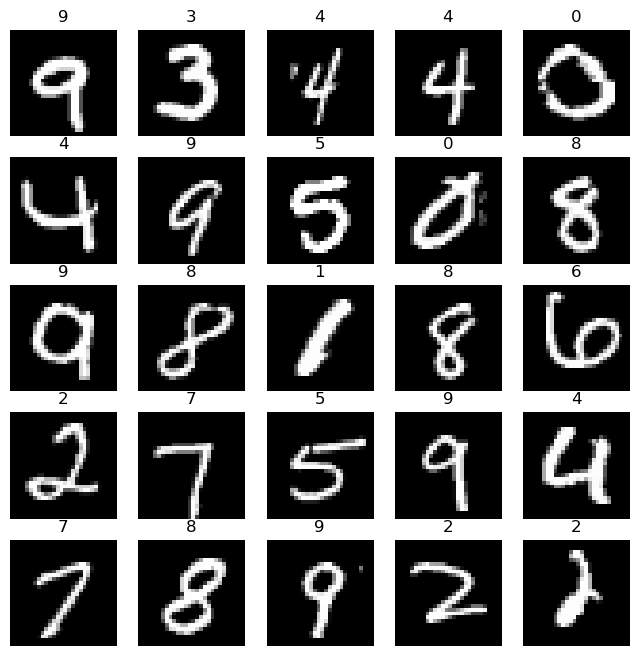

In [2]:
figure = plt.figure(figsize=(8, 8))
cols, rows = 5, 5
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(label)
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()



## Get image patches

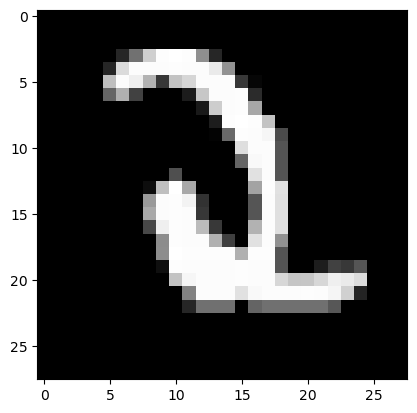

In [3]:
sample_idx = 400
image, label = training_data[sample_idx]
plt.imshow(image.squeeze(), cmap="gray")

patches.shape =  torch.Size([576, 1, 5, 5])


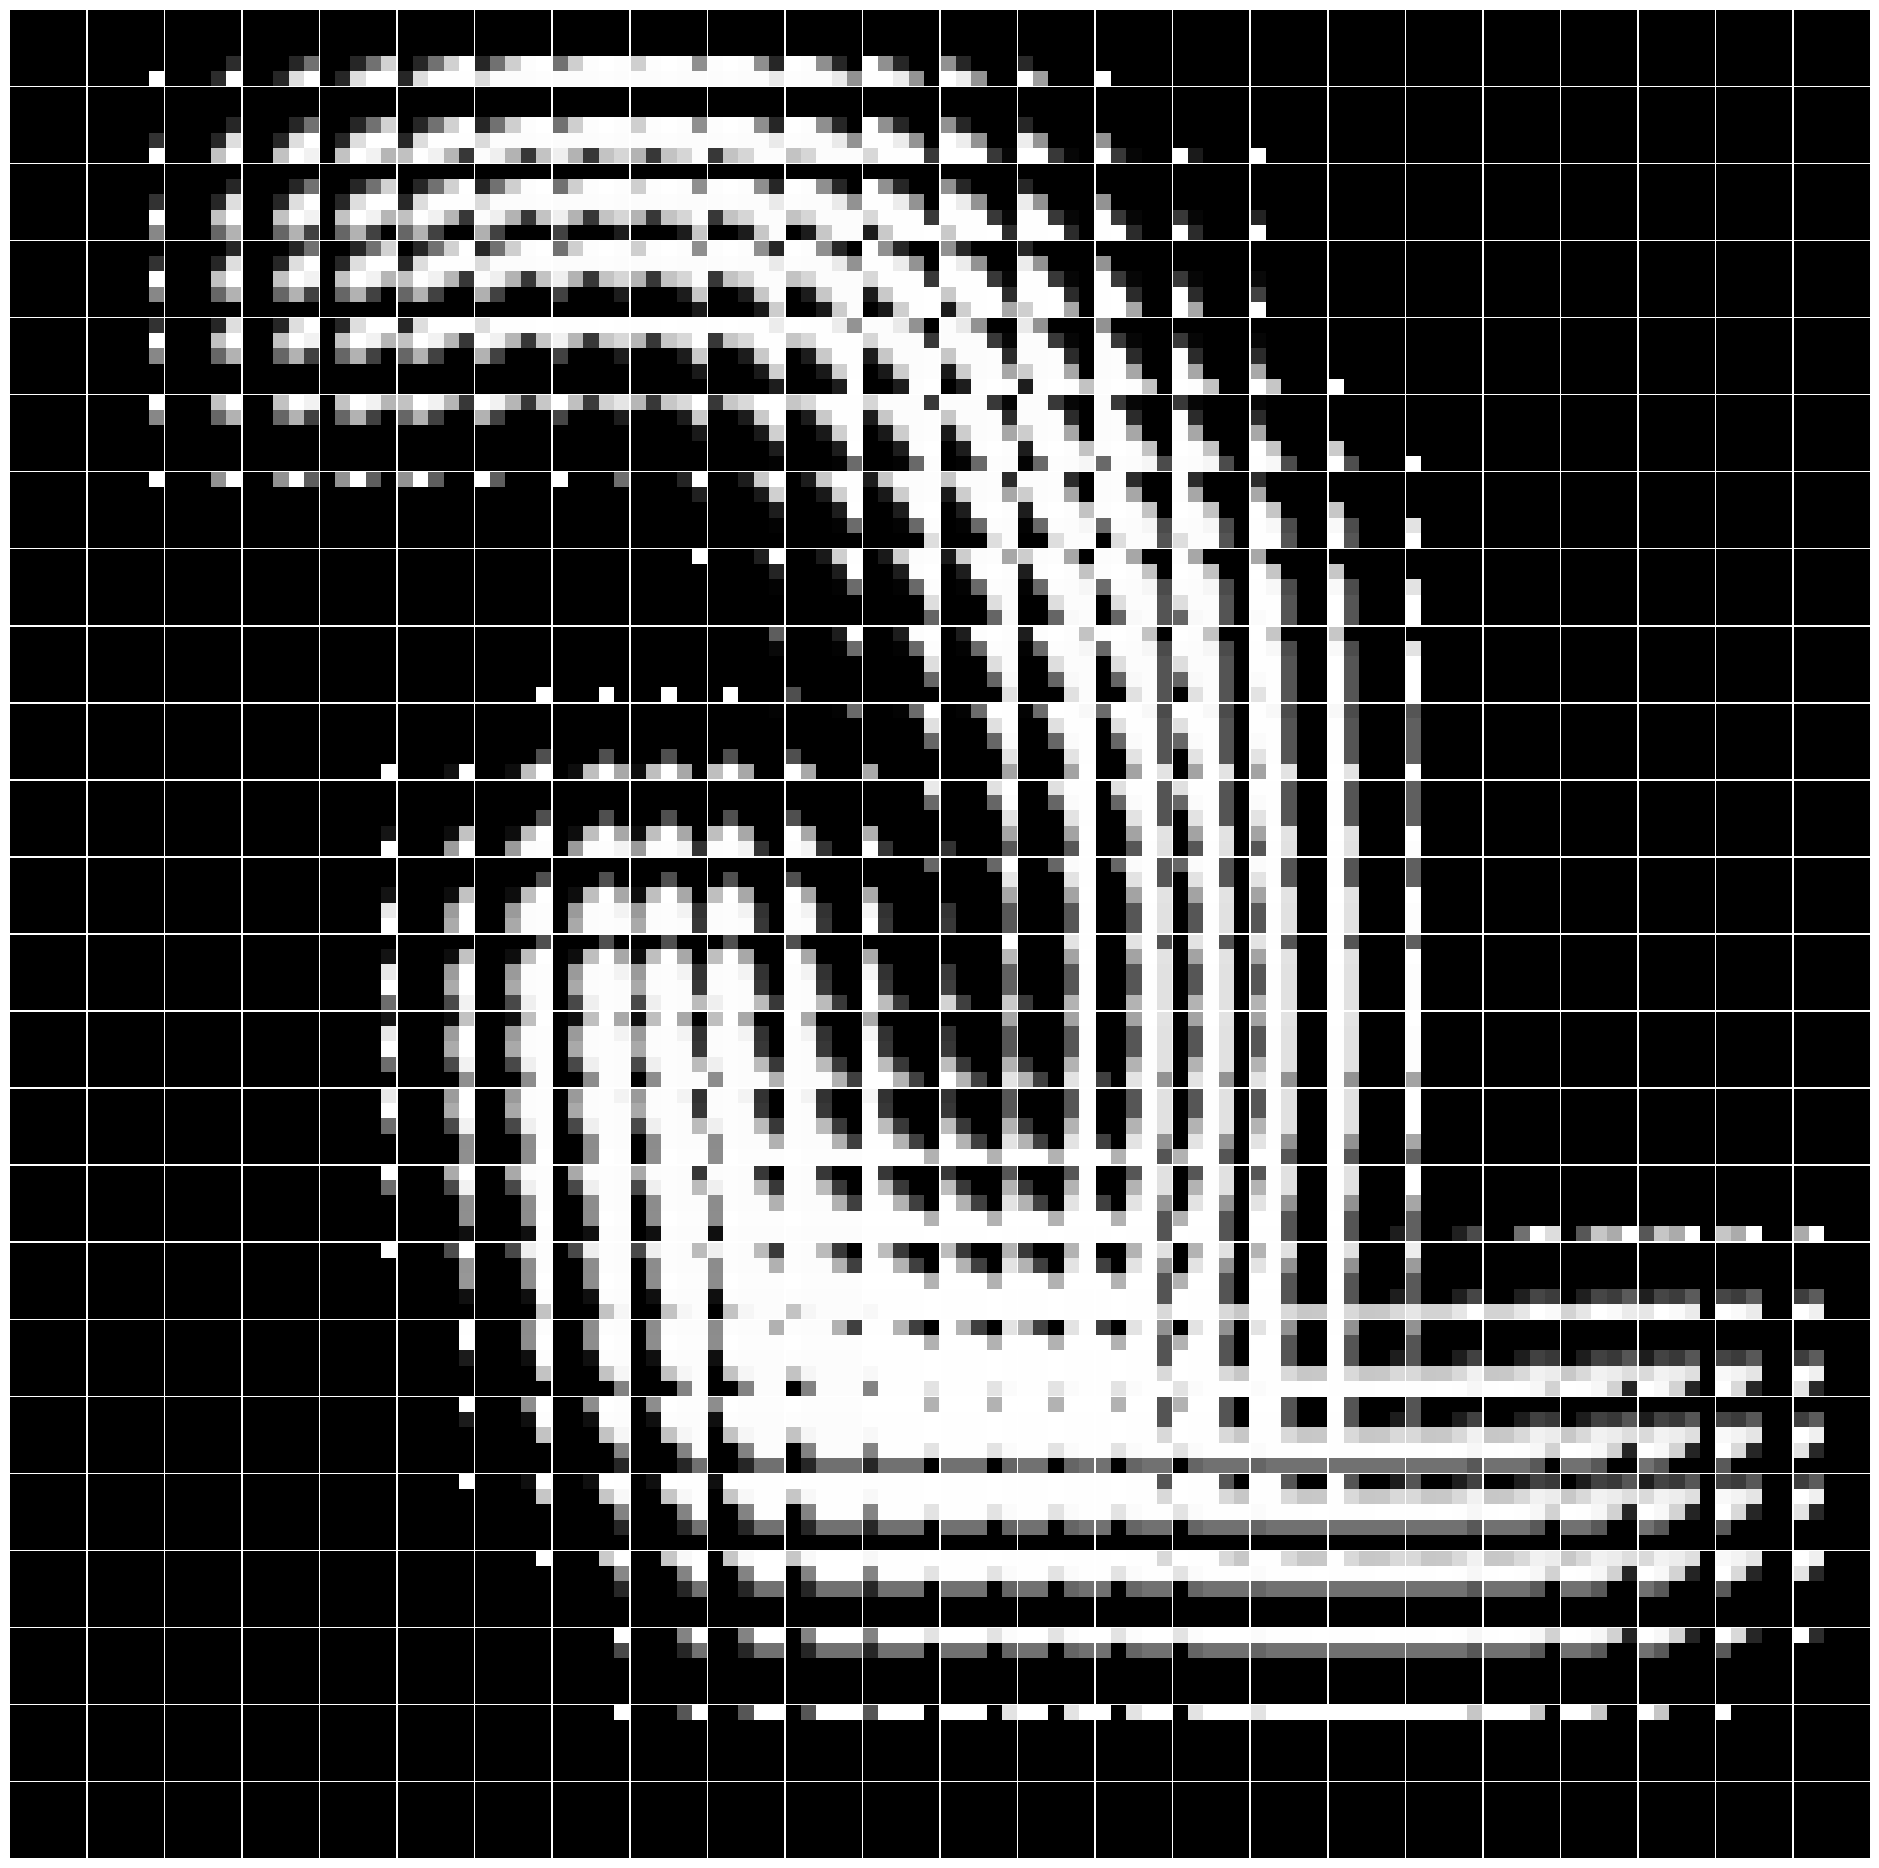

In [4]:
# Reshape to get the patches in the desired shape
patches = Image2Patch(image,plot=False)

NameError: name 'data_batch' is not defined

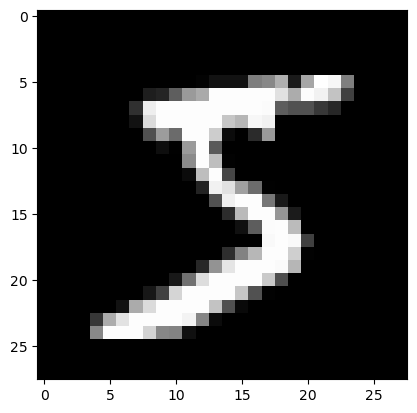

In [5]:
# Initialize model and optimizer
model = SparseCodingModel(input_dim=25, code_dim=10)
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
for epoch in range(10):
    for image in training_data:
        plt.imshow(image[0].squeeze(), cmap="gray")
        optimizer.zero_grad()
        sparse_codes, reconstruction = model(data_batch)
        loss = model.loss(data_batch, sparse_codes, reconstruction)
        loss.backward()
        optimizer.step()
    print(f"Epoch {epoch+1}, Loss: {loss.item()}")